# Cryptocurrency basics

## (a) Finding the nonce

In [120]:
# Modules
import hashlib

# Initial params
nonce = 0
sentence = 'The quick brown fox jumps over the lazy dog'

# Find nonce, hash
while True:
    guess = (str(nonce) + sentence).encode('utf-8')
    guess_hash = hashlib.sha256(guess).hexdigest()
    if guess_hash[-5:] == '0'*5:
        break
    else:
        nonce += 1

# Print results
print('The nonce is', nonce, '; The corresponding hash is', guess_hash)

The nonce is 1622749 ; The corresponding hash is e7c7df9d788c048a522b9d84f889f4daeeed052d46846641c4e5e87f57c00000


## (c) PoW CPU usage

The setup for this question is to initialize five nodes, indexed 5000 through 5004, in our localhost address (see repo for instructions). To do this, I used
```sh
bash tests/payne_nodes.sh init 5
```

The code below is divided in three parts: the first registers the nodes

In [107]:
from paynecoin.utils import req_endpoint, simulate_transaction
import random
import time


# Initial parameters
nodes = [*range(5000, 5005)]

# Register nodes
nodes_register_body = {
    'nodes': [f'http://127.0.0.1:{n}' for n in nodes]
}
for n in nodes:
    req_endpoint('/nodes/register', port=n, data=nodes_register_body)



In [108]:


# Time: initialize registry
wall_times, process_times = [], []

# Loop through periods
for t in range(0, 100):
    # Register a random number of transactions
    # NOTE: this doesn't matter for the end result; we could as well leave it empty
    while True: # Loop until we get `another==False`; could be at first try (ie. no transactions)
        another = random.random() > 0.8  # boolean to break from loop
        if not another:
            break
        else:
            sender = random.choice(nodes)
            recipient = random.choice([n for n in nodes if n is not sender])    # random recipient who is not the sender
            amount = random.uniform(0, 0.2)
            for n in nodes: # manually broadcasting the transaction in all nodes
                req_endpoint(
                    '/transaction',
                    port=n,
                    data=simulate_transaction(sender, recipient, amount)
                )
    
    # Time: start
    wall_start, process_start = time.time(), time.process_time()

    # Mine
    miner = random.choice(nodes)
    req_endpoint('/mine', port=miner)

    # Consensus
    for n in nodes:
        req_endpoint('/nodes/resolve', port=n)
    
    # Time: end
    wall_stop, process_stop = time.time(), time.process_time()
    wall_time, process_time = wall_stop-wall_start, process_stop-process_start

    # Time: register
    wall_times.append(wall_time)
    process_times.append(process_time)




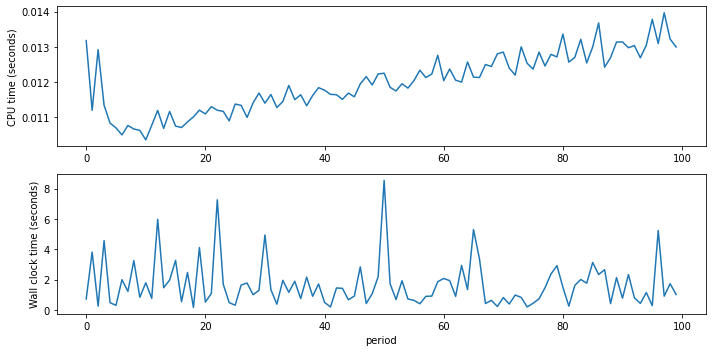

In [121]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# CPU time
plt.subplot(2,1,1)
plt.plot(process_times, label='CPU clock time')
plt.ylabel('CPU time (seconds)')

# Wall-clock times
plt.subplot(2,1,2)
plt.plot(wall_times, label='Wall clock time')
plt.ylabel('Wall clock time (seconds)')
plt.xlabel('period')


plt.tight_layout()
plt.show()

The two figures above plot CPU time and wall-clock time respectively. We note that the latter is not constant, as it fluctuates around a mean of 1.01 second (in my machine). The reason behind this is that with a PoW consensus we are not guaranteed a specific time of completion, because of the brute-force nature of the algorithm. This creates some variance in the time it takes to find a valid proof, which creates variance in CPU-time.